# Propaganda Detection: Code Appendix

This is the code appendix for the Propaganda Detection tasks.

In [1]:
candidate_number = 111111

## Setting up

In this notebook, we will investigate solutions for Propaganda Detection problem.

First, let's load the provided training dataset.

In [2]:
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Uncomment and change path if using Colab

# from google.colab import drive
# drive.mount("/content/drive")

# parentdir = "/content/drive/MyDrive/Advanced NLP/Report A2/propaganda_dataset_v2"
parentdir = "propaganda_dataset_v2"

In [4]:
train_file = "propaganda_train.tsv"
train_path=os.path.join(parentdir,train_file)

test_file = "propaganda_val.tsv"
test_path=os.path.join(parentdir,test_file)

In [5]:
import pandas as pd
train_df = pd.read_csv(train_path,delimiter="\t",quotechar='|')
test_df = pd.read_csv(test_path,delimiter="\t",quotechar='|')

In [6]:
train_df.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,"""The Obama administration misled the <BOS> Ame..."
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


As described, the data contains 2 columns:
- label: represent the correspoding propaganda technique or "not_propaganda"
- tagged_in_context: text in the Propaganda Techniques Corpus (Da San Martino et al., 2020) with \<BOS\> and \<EOS\> tags indicating the propaganda snippet

To address the Propaganda Detection problem, we need to solve 2 separated task:
1. Build a classifier to detect whether a sentence contains propaganda or not.
2. Given a snippet or span of text which is known to contain propaganda, build a classifier to classify the propaganda technique which has been used.

## Data Analysis

In [7]:
print(f"The number of instances in the training set is {train_df.shape[0]}")
print(f"The number of instances in the testing set is {test_df.shape[0]}")

The number of instances in the training set is 2560
The number of instances in the testing set is 640


In [8]:
label_df = train_df.groupby("label").size().reset_index(name="# of sentences")
label_df["% of sentences"] = (label_df["# of sentences"]/label_df["# of sentences"].sum())
label_df

,label,# of sentences,% of sentences
0,appeal_to_fear_prejudice,157,0.061328
1,causal_oversimplification,165,0.064453
2,doubt,157,0.061328
3,"exaggeration,minimisation",170,0.066406
4,flag_waving,155,0.060547
5,loaded_language,161,0.062891
6,"name_calling,labeling",166,0.064844
7,not_propaganda,1269,0.495703
8,repetition,160,0.062500


In [9]:
from sklearn.preprocessing import LabelEncoder

# Label of propaganda and non-propaganda
encoder_1 = LabelEncoder()

train_df['propaganda_label'] = encoder_1.fit_transform(train_df["label"].apply(lambda x: x if x == "not_propaganda" else "propaganda"))
test_df['propaganda_label'] = encoder_1.transform(test_df["label"].apply(lambda x: x if x == "not_propaganda" else "propaganda"))

train_df.head()

,label,tagged_in_context,propaganda_label
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",0
1,not_propaganda,This declassification effort <BOS> won’t make ...,0
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",1
3,not_propaganda,“It looks like we’re capturing the demise of t...,0
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",0


In [10]:
from nltk.tokenize import word_tokenize

# Extract the span of the text and calculate the length of the text and the span
train_df['span'] = train_df['tagged_in_context'].apply(lambda x: x.split('<BOS>')[1].split('<EOS>')[0])
train_df['text_length'] = train_df['tagged_in_context'].apply(lambda x: len(word_tokenize(x)))
train_df['span_length'] = train_df['span'].apply(lambda x: len(word_tokenize(x)))

test_df['span'] = test_df['tagged_in_context'].apply(lambda x: x.split('<BOS>')[1].split('<EOS>')[0])
test_df['text_length'] = test_df['tagged_in_context'].apply(lambda x: len(word_tokenize(x)))
test_df['span_length'] = test_df['span'].apply(lambda x: len(word_tokenize(x)))


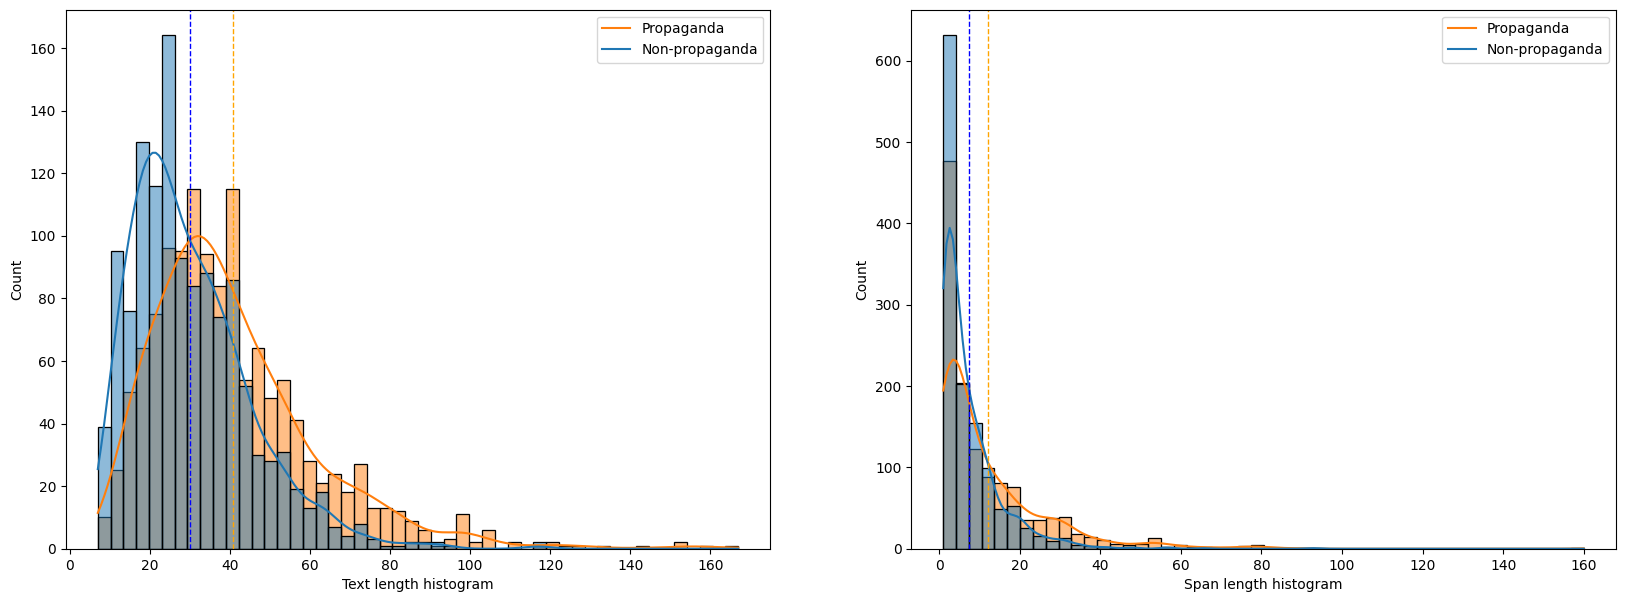

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by the propaganda presence and calculate the average text length and span length
group_df_1 = train_df.groupby('propaganda_label')['text_length'].mean().reset_index()
group_df_1 = group_df_1.merge(train_df.groupby('propaganda_label')['span_length'].mean().reset_index(), on='propaganda_label')
group_df_1.rename(columns={'text_length':'avg_text_length', 'span_length':'avg_span_length'}, inplace=True)
group_df_1.sort_values('propaganda_label')

# Plot the histograms of the text length and span length by propaganda presence
fig, ax = plt.subplots(figsize=(20,7), nrows=1, ncols=2)

sns.histplot(train_df, x="text_length", hue="propaganda_label", bins=50, kde=True, ax=ax[0])
mean_non_propaganda = train_df[train_df['propaganda_label'] == 0]['text_length'].mean()
mean_propaganda = train_df[train_df['propaganda_label'] == 1]['text_length'].mean()
ax[0].axvline(mean_non_propaganda, color='blue', linestyle='dashed', linewidth=1)
ax[0].axvline(mean_propaganda, color='orange', linestyle='dashed', linewidth=1)
ax[0].set_xlabel('Text length histogram')
ax[0].legend(['Propaganda', 'Non-propaganda'])

sns.histplot(train_df, x="span_length", hue="propaganda_label", bins=50, kde=True, ax=ax[1])
mean_non_propaganda = train_df[train_df['propaganda_label'] == 0]['span_length'].mean()
mean_propaganda = train_df[train_df['propaganda_label'] == 1]['span_length'].mean()
ax[1].axvline(mean_non_propaganda, color='blue', linestyle='dashed', linewidth=1)
ax[1].axvline(mean_propaganda, color='orange', linestyle='dashed', linewidth=1)
ax[1].set_xlabel('Span length histogram')
ax[1].legend(['Propaganda', 'Non-propaganda'])

plt.show()

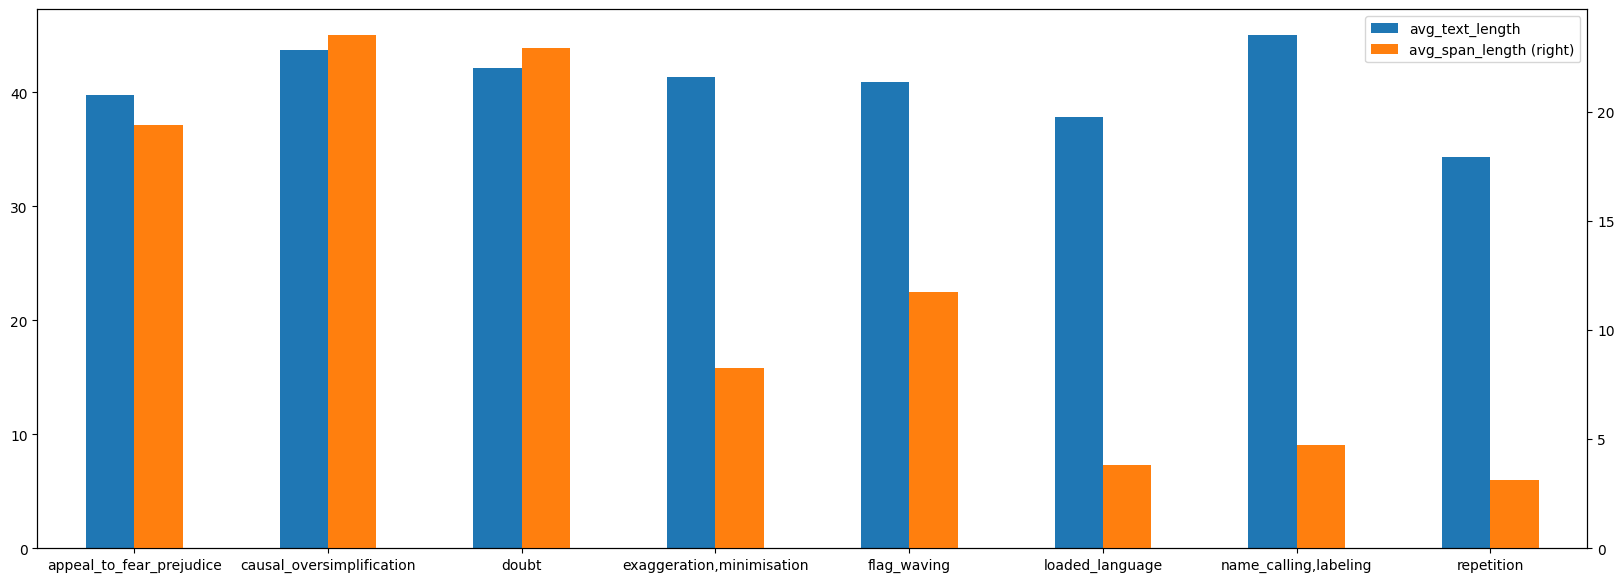

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by the propaganda technique and calculate the average text length and span length
group_df_2 = train_df[train_df['label']!="not_propaganda"].groupby('label')['text_length'].mean().reset_index()
group_df_2 = group_df_2.merge(train_df[train_df['label']!="not_propaganda"].groupby('label')['span_length'].mean().reset_index(), on='label')
group_df_2.rename(columns={'text_length':'avg_text_length', 'span_length':'avg_span_length'}, inplace=True)
group_df_2.sort_values('label')

fig, ax = plt.subplots(figsize=(20,7))

group_df_2.plot(kind='bar', x="label", secondary_y='avg_span_length', rot=0, ax=ax)
ax.set_xlabel('')

plt.show()

Text(0.5, 0, 'Span length histogram')

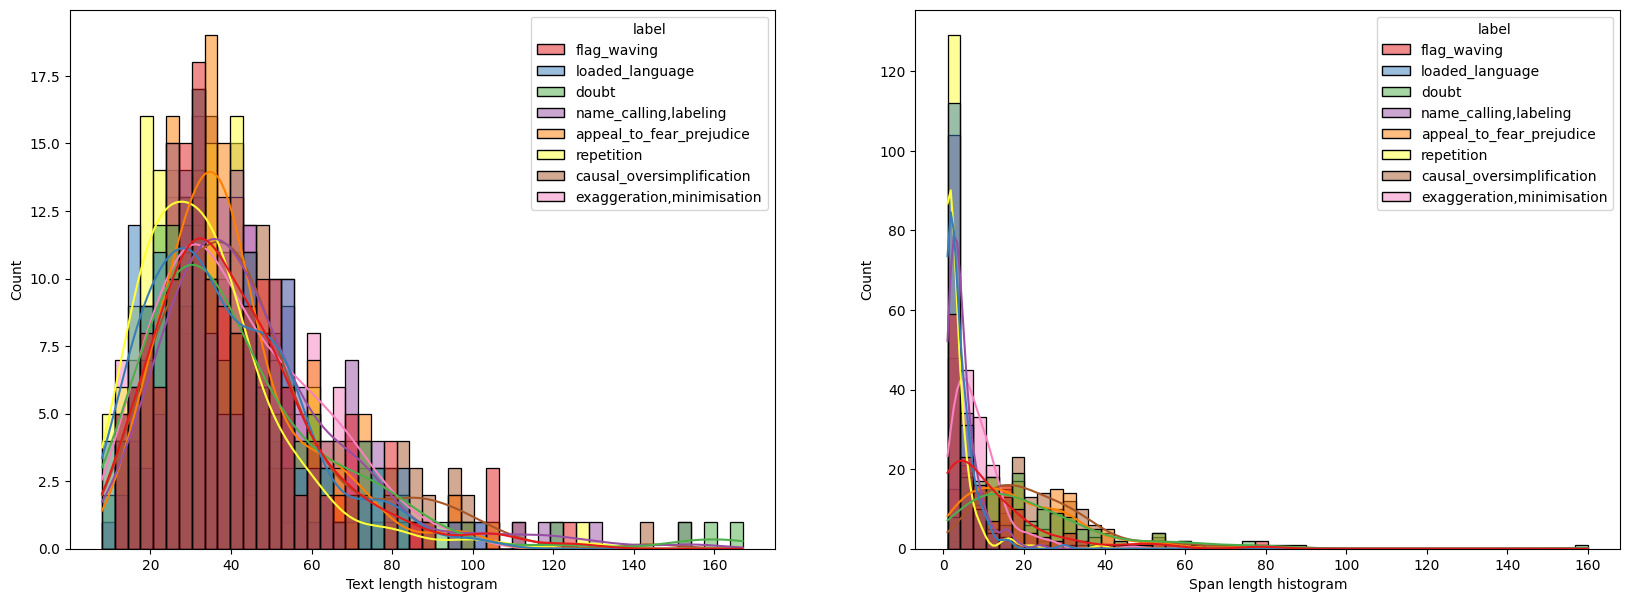

In [13]:
# Plot the histograms of the text length and span length by propaganda technique
fig, ax = plt.subplots(figsize=(20,7), nrows=1, ncols=2)

sns.histplot(train_df[train_df['label']!="not_propaganda"], x="text_length", hue="label", bins=50, kde=True, ax=ax[0], palette='Set1')
ax[0].set_xlabel('Text length histogram')

sns.histplot(train_df[train_df['label']!="not_propaganda"], x="span_length", hue="label", bins=50, kde=True, ax=ax[1], palette='Set1')
ax[1].set_xlabel('Span length histogram')


## Task 1 - Propaganda Presence Detection

propaganda_label
not_propaganda    1269
propaganda        1291
Name: count, dtype: int64


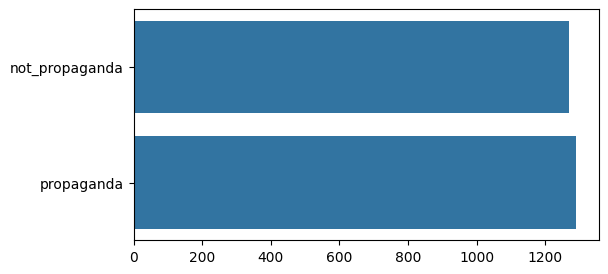

In [14]:
task1_classes = train_df["propaganda_label"].apply(lambda x: encoder_1.classes_[x]).value_counts().sort_values(ascending=True)
print(task1_classes)

fig, ax = plt.subplots(figsize=(6,3))

sns.barplot(ax=ax, y=task1_classes.index, x=task1_classes.values)
ax.set_ylabel('')
plt.show()

For the first task, we will build a classifier with 2 approaches:
- Bag of Words (BOW)
- Pre-trained Large Language Model (BERT)

### 1. Baseline performance

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

X_train, y_train = train_df['text_length'], train_df['propaganda_label']
X_test, y_test = test_df['text_length'], test_df['propaganda_label']

classifier = LogisticRegression(random_state=candidate_number)
classifier.fit(X_train.values.reshape(-1,1), y_train)

y_pred = classifier.predict(X_test.values.reshape(-1,1))
accuracy = accuracy_score(y_test, y_pred)

print(f"The accuracy of the model is {accuracy}")
print(classification_report(y_test, y_pred, target_names=encoder_1.classes_))

The accuracy of the model is 0.5953125
                precision    recall  f1-score   support

not_propaganda       0.59      0.70      0.64       331
    propaganda       0.60      0.49      0.54       309

      accuracy                           0.60       640
     macro avg       0.60      0.59      0.59       640
  weighted avg       0.60      0.60      0.59       640



### 2. Bag of Words

#### a) Encode the target variable and Set up the training & testing data

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV


X_train, y_train = train_df['tagged_in_context'], train_df['propaganda_label']
X_test, y_test = test_df['tagged_in_context'], test_df['propaganda_label']

#### b) Run with different algorithms and configs to find the best combination

In [17]:
vectorizer_params = {
    'ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
    'analyzer': ['word', 'char', 'char_wb'],
}

classifiers = [
    {'model': MultinomialNB(), 'params': {}},
    {'model': LogisticRegression(), 'params': {'penalty': ['l1','l2'], 'C': [0.1, 1, 10], 'max_iter': [10000]}},
    {'model': RandomForestClassifier(), 'params': {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], "random_state":[candidate_number]}},
    {'model': KNeighborsClassifier(), 'params': {'n_neighbors': [len(train_df["propaganda_label"].unique())], 'weights': ['uniform', 'distance']}},
    {'model': SVC(), 'params': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], "random_state":[candidate_number]}},
]

In [18]:
# it takes 9 minutes to run

for config in classifiers:
    print(f"Training {config['model'].__class__.__name__}...")
    best_accuracy = 0
    best_parameters = None
    best_model = None
    best_y_pred = None
    best_vectorizer = None
    for ngram_range in tqdm(vectorizer_params['ngram_range']):
        for analyzer in tqdm(vectorizer_params['analyzer'], leave=False):
            vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer=analyzer)
            X_train_vector = vectorizer.fit_transform(X_train)
            X_test_vector = vectorizer.transform(X_test)

            classifier = config['model']
            grid_params = config['params']

            grid_search = GridSearchCV(classifier, grid_params, n_jobs=-1)
            grid_search.fit(X_train_vector, y_train)
            model = grid_search.best_estimator_

            y_pred = model.predict(X_test_vector)
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_parameters = grid_search.best_params_
                best_model = grid_search.best_estimator_
                best_y_pred = y_pred
                best_vectorizer = vectorizer
    print(f"{classifier.__class__.__name__} (Params: {best_parameters}) with vectorizer (ngram_range:{best_vectorizer.get_params()['ngram_range']}, analyzer:{best_vectorizer.get_params()['analyzer']}):")
    print(f"Validation Accuracy:", best_accuracy)
    print(classification_report(y_test, best_y_pred, target_names=encoder_1.classes_))
    print("-" * 20)


Training MultinomialNB...


100%|██████████| 5/5 [00:05<00:00,  1.06s/it]


MultinomialNB (Params: {}) with vectorizer (ngram_range:(4, 4), analyzer:char):
Validation Accuracy: 0.8375
                precision    recall  f1-score   support

not_propaganda       0.87      0.81      0.84       331
    propaganda       0.81      0.87      0.84       309

      accuracy                           0.84       640
     macro avg       0.84      0.84      0.84       640
  weighted avg       0.84      0.84      0.84       640

--------------------
Training LogisticRegression...


100%|██████████| 5/5 [00:16<00:00,  3.35s/it]


LogisticRegression (Params: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2'}) with vectorizer (ngram_range:(5, 5), analyzer:char):
Validation Accuracy: 0.871875
                precision    recall  f1-score   support

not_propaganda       0.83      0.95      0.88       331
    propaganda       0.94      0.79      0.86       309

      accuracy                           0.87       640
     macro avg       0.88      0.87      0.87       640
  weighted avg       0.88      0.87      0.87       640

--------------------
Training RandomForestClassifier...


100%|██████████| 5/5 [04:23<00:00, 52.74s/it]


RandomForestClassifier (Params: {'max_depth': None, 'n_estimators': 200, 'random_state': 277269}) with vectorizer (ngram_range:(5, 5), analyzer:char_wb):
Validation Accuracy: 0.8609375
                precision    recall  f1-score   support

not_propaganda       0.83      0.92      0.87       331
    propaganda       0.90      0.80      0.85       309

      accuracy                           0.86       640
     macro avg       0.87      0.86      0.86       640
  weighted avg       0.87      0.86      0.86       640

--------------------
Training KNeighborsClassifier...


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


KNeighborsClassifier (Params: {'n_neighbors': 2, 'weights': 'distance'}) with vectorizer (ngram_range:(5, 5), analyzer:char):
Validation Accuracy: 0.7234375
                precision    recall  f1-score   support

not_propaganda       0.66      0.95      0.78       331
    propaganda       0.91      0.48      0.62       309

      accuracy                           0.72       640
     macro avg       0.78      0.72      0.70       640
  weighted avg       0.78      0.72      0.71       640

--------------------
Training SVC...


100%|██████████| 5/5 [03:44<00:00, 44.82s/it]

SVC (Params: {'C': 10, 'kernel': 'rbf', 'random_state': 277269}) with vectorizer (ngram_range:(4, 4), analyzer:char):
Validation Accuracy: 0.8609375
                precision    recall  f1-score   support

not_propaganda       0.84      0.90      0.87       331
    propaganda       0.89      0.82      0.85       309

      accuracy                           0.86       640
     macro avg       0.86      0.86      0.86       640
  weighted avg       0.86      0.86      0.86       640

--------------------


### 3. Pre-trained Large Language Model - BERT

#### a) First, we define a torch Dataset class to store the training and testing data

In [19]:
import torch
import numpy as np
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


class Dataset_Bert(torch.utils.data.Dataset):
    def __init__(self, df, sents='tagged_in_context', labels="propaganda_label", max_length=256, padding='max_length'):
        self.labels = [torch.tensor(label, dtype=torch.long) for label in df[labels]]
        self.texts = [bert_tokenizer(text.lower(),padding=padding,max_length=max_length,truncation=True,return_tensors="pt") for text in df[sents]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return self.labels[idx]

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self,idx):
        batch_texts=self.get_batch_texts(idx)
        batch_y=self.get_batch_labels(idx)

        return batch_texts,batch_y

#### b) Define the training loop and model valuation using BertForSequenceClassification

In [20]:
from transformers import AdamW
import gc


def train_bert(model, train_data, val_data, learning_rate, epochs, batch_size):
    if torch.cuda.is_available():  # Use GPU if available
        device = torch.device("cuda")
        torch.cuda.empty_cache()
        gc.collect()
    elif torch.backends.mps.is_available():
        device = torch.device("mps")  # Use GPU for MacOS
        torch.mps.empty_cache()
        gc.collect()
    else:
        device = torch.device("cpu")

    model.to(device)

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # Initialize best validation loss for early stopping
    best_val_loss = float('inf')
    patience = 5

    for epoch_num in range(epochs):
        # print(f"Epochs: {epoch_num+1}/{epochs}")
        total_acc_train=0
        total_loss_train=0

        model.train()
        for batch in tqdm(train_dataloader, desc=f"Training epoch: {epoch_num+1}/{epochs}", leave=False):
            train_input, train_label = (instance.to(device) for instance in batch)
            input_id = train_input['input_ids'].squeeze(1)
            mask = train_input['attention_mask']
            output = model(input_ids=input_id, attention_mask=mask, labels=train_label)

            batch_loss = output.loss
            total_loss_train += batch_loss.item()

            acc=(output.logits.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Testing epoch: {epoch_num+1}/{epochs}",leave=False):
                val_input, val_label = (instance.to(device) for instance in batch)
                input_id = val_input['input_ids'].squeeze(1)
                mask = val_input['attention_mask']
                output = model(input_ids=input_id, attention_mask=mask, labels=val_label)

                batch_loss = output.loss
                total_loss_val += batch_loss.item()

                acc = (output.logits.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        # Early stopping
        if total_loss_val < best_val_loss:
            best_val_loss = total_loss_val
            patience = 5  # Reset patience counter on improvement
        else:
            patience -= 1

        if patience == 0:
            print(f"Early Stopping: Validation loss hasn't improved after {epoch_num} epochs. Stopping training.")
            break

        # print(f'Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
    # print(f'Val loss: {best_val_loss/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
    # print("---")
    return total_acc_val / len(val_data)


#### c) Run the model and tuning hyperparameter

In [21]:
from copy import deepcopy

def tune_hyperparameters(train_fn, model, train_data, val_data, configs):
    best_val_acc = 0
    best_model_state_dict = None
    best_config = None

    initial_state = deepcopy(model.state_dict())  # Save initial model state
    epochs = configs['EPOCHS']
    for lr in configs['LR']:
        for batch_size in configs['BATCH_SIZE']:
            print(f"Training with: epochs={epochs}, lr={lr}, batch_size={batch_size}")
            model.load_state_dict(initial_state)  # Reset model to initial state for each configuration
            val_acc = train_fn(model, train_data, val_data, learning_rate=lr, epochs=epochs, batch_size=batch_size)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state_dict = deepcopy(model.state_dict())
                best_config = (epochs, lr, batch_size)
            print(f"Val Accuracy: {val_acc:.3f}")
            print("----------")

    print(f"Best validation accuracy: {best_val_acc:.3f}")
    print(f"Best configuration: epochs={best_config[0]}, lr={best_config[1]}, batch_size={best_config[2]}")

    #Load best model weights
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return model, best_config


In [22]:
def bert_model_report(model, val_data, batch_size, classes=encoder_1.classes_):
    if torch.cuda.is_available():  # Use GPU if available
        device = torch.device("cuda")
        torch.cuda.empty_cache()
        gc.collect()
    elif torch.backends.mps.is_available():
        device = torch.device("mps")  # Use GPU for MacOS
        torch.mps.empty_cache()
        gc.collect()
    else:
        device = torch.device("cpu")

    model.to(device)
    model.eval()
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    total_acc_val = 0
    total_loss_val = 0
    pred_labels, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            val_input, val_label = (instance.to(device) for instance in batch)
            input_id = val_input['input_ids'].squeeze(1)
            mask = val_input['attention_mask']
            output = model(input_ids=input_id, attention_mask=mask, labels=val_label)

            pred = output.logits.argmax(dim=1)

            acc = (output.logits.argmax(dim=1) == val_label).sum().item()
            total_acc_val += acc

            batch_loss = output.loss
            total_loss_val += batch_loss.item()

            pred_labels += pred.cpu()
            true_labels += val_label.cpu()

    print(f'Best loss: {total_loss_val/len(val_data):.3f} | Best Accuracy: {total_acc_val / len(val_data):.3f}')
    print(classification_report(true_labels, pred_labels, target_names=classes))

In [23]:
train_data = Dataset_Bert(train_df)
test_data = Dataset_Bert(test_df)

##### Tuning hyperparameter, this takes 160 minutes to run

In [24]:
configs = {
    'EPOCHS': 10,
    'LR': [1e-5, 5e-5],
    'BATCH_SIZE': [16, 8, 2]
    # 'EPOCHS': 1,
    # 'LR': [1e-5],
    # 'BATCH_SIZE': [2]
}

In [25]:
# it takes 160 minutes to run

from transformers import BertForSequenceClassification

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
best_bert_binary, best_config_binary = tune_hyperparameters(train_bert, bert_model, train_data, test_data, configs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with: epochs=10, lr=1e-05, batch_size=16


Early Stopping: Validation loss hasn't improved after 7 epochs. Stopping training.
Val Accuracy: 0.948
----------
Training with: epochs=10, lr=1e-05, batch_size=8


Early Stopping: Validation loss hasn't improved after 7 epochs. Stopping training.
Val Accuracy: 0.952
----------
Training with: epochs=10, lr=1e-05, batch_size=2


Early Stopping: Validation loss hasn't improved after 8 epochs. Stopping training.
Val Accuracy: 0.945
----------
Training with: epochs=10, lr=5e-05, batch_size=16


Early Stopping: Validation loss hasn't improved after 7 epochs. Stopping training.
Val Accuracy: 0.936
----------
Training with: epochs=10, lr=5e-05, batch_size=8


Early Stopping: Validation loss hasn't improved after 6 epochs. Stopping training.
Val Accuracy: 0.912
----------
Training with: epochs=10, lr=5e-05, batch_size=2


Early Stopping: Validation loss hasn't improved after 6 epochs. Stopping training.
Val Accuracy: 0.483
----------
Best validation accuracy: 0.952
Best configuration: epochs=10, lr=1e-05, batch_size=8


##### Best model's performance

In [26]:
bert_model_report(best_bert_binary, test_data, best_config_binary[2])

100%|██████████| 80/80 [00:11<00:00,  6.85it/s]

Best loss: 0.024 | Best Accuracy: 0.952
                precision    recall  f1-score   support

not_propaganda       0.96      0.95      0.95       331
    propaganda       0.95      0.95      0.95       309

      accuracy                           0.95       640
     macro avg       0.95      0.95      0.95       640
  weighted avg       0.95      0.95      0.95       640



### 4. Neural Network Model

#### a) First, we define a torch Dataset class to store the training and testing data

In [27]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

torch_tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter, sents="tagged_in_context"):
    for row in data_iter[sents]:
        yield torch_tokenizer(row)

vocab = build_vocab_from_iterator(yield_tokens(train_df), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
vocab_size = len(vocab)


class Dataset_NN(torch.utils.data.Dataset):
    def __init__(self, df, sents='tagged_in_context', labels="propaganda_label"):
        self.labels = [torch.tensor(label, dtype=torch.long) for label in df[labels]]
        self.texts = [torch.tensor(vocab(torch_tokenizer(text)), dtype=torch.long) for text in df[sents]]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return self.labels[idx]

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):
        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

#### b) Define an Neural Network classification model.

In [28]:
import torch.nn as nn


class NNClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, embed_mode="sum", num_classes=2):
        super(NNClassifier, self).__init__()

        self.embeddings = nn.EmbeddingBag(vocab_size, embed_dim, mode=embed_mode, sparse=False)
        self.linear = nn.Linear(embed_dim, num_classes)

    def forward(self, inputs):
        embeds = self.embeddings(inputs)
        final_layer = self.linear(embeds)
        return final_layer

#### c) Define the training loop and model valuation

In [29]:
from torch.optim import Adam


def train_nn(model, train_data, val_data, learning_rate, epochs, batch_size):
    device = torch.device("cpu")  # EmbeddingBag is not supported on GPU
    model.to(device)

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    # Initialize best validation loss for early stopping
    best_val_loss = float('inf')
    patience = 5

    for epoch_num in range(epochs):
        # print(f"Epochs: {epoch_num+1}/{epochs}")
        total_acc_train=0
        total_loss_train=0
        model.train()
        for batch in tqdm(train_dataloader, desc=f"Training epoch: {epoch_num+1}/{epochs}", leave=False):
            train_input, train_label = (instance.to(device) for instance in batch)
            output = model(train_input)

            batch_loss = criterion(output,train_label)
            total_loss_train += batch_loss.item()

            acc=(output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc=f"Testing epoch: {epoch_num+1}/{epochs}",leave=False):
                val_input,val_label = (instance.to(device) for instance in batch)
                output = model(val_input)

                batch_loss = criterion(output,val_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

        # Early stopping
        if total_loss_val < best_val_loss:
            best_val_loss = total_loss_val
            patience = 5  # Reset patience counter on improvement
        else:
            patience -= 1

        if patience == 0:
            print(f"Early Stopping: Validation loss hasn't improved after {epoch_num} epochs. Stopping training.")
            break

        # print(f'Train Loss: {total_loss_train / len(train_data):.3f} | Train Accuracy: {total_acc_train/len(train_data):.3f}')
    # print(f'Val loss: {total_loss_val/len(val_data):.3f} | Val Accuracy: {total_acc_val / len(val_data):.3f}')
    # print("---")
    return total_acc_val / len(val_data)


#### d) Run the model and tuning hyperparameter

In [30]:
from copy import deepcopy

def tune_hyperparameters(train_fn, model, train_data, val_data, configs):
    best_val_acc = 0
    best_model_state_dict = None
    best_config = None

    initial_state = deepcopy(model.state_dict())  # Save initial model state
    epochs = configs['EPOCHS']
    for lr in configs['LR']:
        for batch_size in configs['BATCH_SIZE']:
            print(f"Training with: epochs={epochs}, lr={lr}, batch_size={batch_size}")
            model.load_state_dict(initial_state)  # Reset model to initial state for each configuration
            val_acc = train_fn(model, train_data, val_data, learning_rate=lr, epochs=epochs, batch_size=batch_size)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state_dict = deepcopy(model.state_dict())
                best_config = (epochs, lr, batch_size)
            print(f"Val Accuracy: {val_acc:.3f}")
            print("----------")

    print(f"Best validation accuracy: {best_val_acc:.3f}")
    print(f"Best configuration: epochs={best_config[0]}, lr={best_config[1]}, batch_size={best_config[2]}")

    #Load best model weights
    if best_model_state_dict is not None:
        model.load_state_dict(best_model_state_dict)

    return model, best_config


In [31]:
def nn_model_report(model, val_data, batch_size, classes=encoder_1.classes_):
    device = torch.device("cpu")
    model.to(device)

    model.eval()
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    criterion = nn.CrossEntropyLoss()

    total_acc_val = 0
    total_loss_val = 0
    pred_labels, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(val_dataloader):
            val_input,val_label = (instance.to(device) for instance in batch)
            output = model(val_input)

            pred = output.argmax(dim=1)

            acc = (pred == val_label).sum().item()
            total_acc_val += acc

            batch_loss = criterion(output,val_label)
            total_loss_val += batch_loss.item()

            pred_labels += pred.cpu()
            true_labels += val_label.cpu()

    print(f'Best loss: {total_loss_val/len(val_data):.3f} | Best Accuracy: {total_acc_val / len(val_data):.3f}')
    print(classification_report(true_labels, pred_labels, target_names=classes))

In [32]:
train_data = Dataset_NN(train_df)
test_data = Dataset_NN(test_df)

##### Tuning hyperparameter, this takes 15 minutes to run

In [33]:
configs = {
    'EPOCHS': 100,
    'LR': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    'BATCH_SIZE': [1]  # Batch size = 1 for using EmbeddingBag with different tensor lengths
}

In [34]:
# it takes 15 minutes to run

nn_model = NNClassifier(vocab_size=vocab_size, embed_dim=128)
best_nn_model, best_nn_config = tune_hyperparameters(train_nn, nn_model, train_data, test_data, configs)

Training with: epochs=100, lr=1e-05, batch_size=1


Early Stopping: Validation loss hasn't improved after 76 epochs. Stopping training.
Val Accuracy: 0.669
----------
Training with: epochs=100, lr=5e-05, batch_size=1


Early Stopping: Validation loss hasn't improved after 22 epochs. Stopping training.
Val Accuracy: 0.662
----------
Training with: epochs=100, lr=0.0001, batch_size=1


Early Stopping: Validation loss hasn't improved after 12 epochs. Stopping training.
Val Accuracy: 0.672
----------
Training with: epochs=100, lr=0.0005, batch_size=1


Early Stopping: Validation loss hasn't improved after 7 epochs. Stopping training.
Val Accuracy: 0.689
----------
Training with: epochs=100, lr=0.001, batch_size=1


Early Stopping: Validation loss hasn't improved after 5 epochs. Stopping training.
Val Accuracy: 0.700
----------
Training with: epochs=100, lr=0.005, batch_size=1


Early Stopping: Validation loss hasn't improved after 5 epochs. Stopping training.
Val Accuracy: 0.697
----------
Training with: epochs=100, lr=0.01, batch_size=1


Early Stopping: Validation loss hasn't improved after 5 epochs. Stopping training.
Val Accuracy: 0.691
----------
Best validation accuracy: 0.700
Best configuration: epochs=100, lr=0.001, batch_size=1


##### Best model's performance

In [35]:
nn_model_report(best_nn_model, test_data, best_nn_config[2])

100%|██████████| 640/640 [00:00<00:00, 9643.05it/s]

Best loss: 1.646 | Best Accuracy: 0.700
                precision    recall  f1-score   support

not_propaganda       0.68      0.80      0.73       331
    propaganda       0.74      0.59      0.65       309

      accuracy                           0.70       640
     macro avg       0.71      0.70      0.69       640
  weighted avg       0.71      0.70      0.70       640



## Task 2 - Propaganda Technique Classification

In [36]:
encoder_2 = LabelEncoder()

train_df_2 = train_df[train_df['label'] != "not_propaganda"].copy()
train_df_2['technique_label'] = encoder_2.fit_transform(train_df_2['label'])

test_df_2 = test_df[test_df['label'] != "not_propaganda"].copy()
test_df_2['technique_label'] = encoder_2.transform(test_df_2['label'])

train_df_2.head()

,label,tagged_in_context,propaganda_label,span,text_length,span_length,technique_label
2,flag_waving,"""The Obama administration misled the <BOS> Ame...",1,American people,31,2,4
5,loaded_language,"Hitler <BOS> annihilated <EOS> 400,000 Germans...",1,annihilated,19,1,5
8,doubt,"As noted above, at this point literally every ...",1,so-called evidence,44,2,2
10,"name_calling,labeling",His account was suspended for violating Twitte...,1,hateful conduct,40,2,6
12,appeal_to_fear_prejudice,A couple of seemingly unrelated events this pa...,1,point to Iran’s positioning itself for more a...,38,22,0


### 1. Baseline performance

In [37]:
X_train, y_train = train_df_2['span_length'], train_df_2['technique_label']
X_test, y_test = test_df_2['span_length'], test_df_2['technique_label']

classifier = LogisticRegression(random_state=candidate_number)
classifier.fit(X_train.values.reshape(-1,1), y_train)

y_pred = classifier.predict(X_test.values.reshape(-1,1))
accuracy = accuracy_score(y_test, y_pred)

print(f"The accuracy of the model is {accuracy*100}%")
print(classification_report(y_test, y_pred, target_names=encoder_2.classes_))

The accuracy of the model is 22.653721682847898%
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.20      0.07      0.10        43
causal_oversimplification       0.26      0.69      0.38        35
                    doubt       0.00      0.00      0.00        43
exaggeration,minimisation       0.14      0.23      0.17        30
              flag_waving       0.11      0.04      0.06        45
          loaded_language       0.00      0.00      0.00        39
    name_calling,labeling       0.21      0.21      0.21        34
               repetition       0.27      0.68      0.38        40

                 accuracy                           0.23       309
                macro avg       0.15      0.24      0.16       309
             weighted avg       0.15      0.23      0.16       309



### 2. Bag of Words

#### a) Run with features from text vectorization

In [38]:
# it takes 10 minutes to run

X_train, y_train = train_df_2['tagged_in_context'], train_df_2['technique_label']
X_test, y_test = test_df_2['tagged_in_context'], test_df_2['technique_label']

vectorizer_params = {
    'ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
    'analyzer': ['word', 'char', 'char_wb'],
}

classifiers = [
    {'model': MultinomialNB(), 'params': {}},
    {'model': LogisticRegression(), 'params': {'penalty': ['l1','l2'], 'C': [0.1, 1, 10], 'max_iter': [10000]}},
    {'model': RandomForestClassifier(), 'params': {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], "random_state":[candidate_number]}},
    {'model': KNeighborsClassifier(), 'params': {'n_neighbors': [len(train_df_2["label"].unique())], 'weights': ['uniform', 'distance']}},
    {'model': SVC(), 'params': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], "random_state":[candidate_number]}},
]

for config in classifiers:
    print(f"Training {config['model'].__class__.__name__}...")
    best_accuracy = 0
    best_parameters = None
    best_model = None
    best_y_pred = None
    best_vectorizer = None
    for ngram_range in tqdm(vectorizer_params['ngram_range']):
        for analyzer in tqdm(vectorizer_params['analyzer'],leave=False):
            vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer=analyzer)
            X_train_vector = vectorizer.fit_transform(X_train)
            X_test_vector = vectorizer.transform(X_test)

            classifier = config['model']
            grid_params = config['params']

            grid_search = GridSearchCV(classifier, grid_params, n_jobs=-1)
            grid_search.fit(X_train_vector, y_train)
            model = grid_search.best_estimator_

            y_pred = model.predict(X_test_vector)
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_parameters = grid_search.best_params_
                best_model = grid_search.best_estimator_
                best_y_pred = y_pred
                best_vectorizer = vectorizer
    print(f"{classifier.__class__.__name__} (Params: {best_parameters}) with vectorizer (ngram_range:{best_vectorizer.get_params()['ngram_range']}, analyzer:{best_vectorizer.get_params()['analyzer']}):")
    print(f"Validation Accuracy:", best_accuracy)
    print(classification_report(y_test, best_y_pred, target_names=encoder_2.classes_))
    print("-" * 20)


Training MultinomialNB...


100%|██████████| 5/5 [00:05<00:00,  1.07s/it]


MultinomialNB (Params: {}) with vectorizer (ngram_range:(4, 4), analyzer:char):
Validation Accuracy: 0.4077669902912621
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.44      0.44      0.44        43
causal_oversimplification       0.37      0.57      0.45        35
                    doubt       0.42      0.49      0.45        43
exaggeration,minimisation       0.33      0.47      0.38        30
              flag_waving       0.57      0.67      0.61        45
          loaded_language       0.21      0.08      0.11        39
    name_calling,labeling       0.27      0.21      0.23        34
               repetition       0.46      0.30      0.36        40

                 accuracy                           0.41       309
                macro avg       0.38      0.40      0.38       309
             weighted avg       0.39      0.41      0.39       309

--------------------
Training LogisticRegression...


100%|██████████| 5/5 [01:40<00:00, 20.17s/it]


LogisticRegression (Params: {'C': 0.1, 'max_iter': 10000, 'penalty': 'l2'}) with vectorizer (ngram_range:(5, 5), analyzer:char):
Validation Accuracy: 0.4627831715210356
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.47      0.42      0.44        43
causal_oversimplification       0.41      0.49      0.45        35
                    doubt       0.48      0.56      0.52        43
exaggeration,minimisation       0.38      0.53      0.44        30
              flag_waving       0.68      0.62      0.65        45
          loaded_language       0.42      0.28      0.34        39
    name_calling,labeling       0.43      0.38      0.41        34
               repetition       0.39      0.40      0.40        40

                 accuracy                           0.46       309
                macro avg       0.46      0.46      0.46       309
             weighted avg       0.47      0.46      0.46       309

--------------------
Tra

100%|██████████| 5/5 [02:01<00:00, 24.36s/it]


RandomForestClassifier (Params: {'max_depth': None, 'n_estimators': 200, 'random_state': 277269}) with vectorizer (ngram_range:(5, 5), analyzer:char):
Validation Accuracy: 0.4336569579288026
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.57      0.30      0.39        43
causal_oversimplification       0.39      0.66      0.49        35
                    doubt       0.49      0.42      0.45        43
exaggeration,minimisation       0.33      0.37      0.35        30
              flag_waving       0.60      0.69      0.64        45
          loaded_language       0.26      0.33      0.29        39
    name_calling,labeling       0.52      0.35      0.42        34
               repetition       0.41      0.33      0.36        40

                 accuracy                           0.43       309
                macro avg       0.44      0.43      0.42       309
             weighted avg       0.45      0.43      0.43       309

--

100%|██████████| 5/5 [00:03<00:00,  1.56it/s]


KNeighborsClassifier (Params: {'n_neighbors': 8, 'weights': 'distance'}) with vectorizer (ngram_range:(2, 2), analyzer:char):
Validation Accuracy: 0.24919093851132687
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.32      0.21      0.25        43
causal_oversimplification       0.24      0.31      0.27        35
                    doubt       0.26      0.21      0.23        43
exaggeration,minimisation       0.11      0.17      0.13        30
              flag_waving       0.47      0.44      0.45        45
          loaded_language       0.12      0.08      0.10        39
    name_calling,labeling       0.16      0.09      0.11        34
               repetition       0.24      0.42      0.31        40

                 accuracy                           0.25       309
                macro avg       0.24      0.24      0.23       309
             weighted avg       0.25      0.25      0.24       309

--------------------
Train

100%|██████████| 5/5 [06:19<00:00, 75.92s/it] 

SVC (Params: {'C': 0.1, 'kernel': 'linear', 'random_state': 277269}) with vectorizer (ngram_range:(5, 5), analyzer:char):
Validation Accuracy: 0.47896440129449835
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.49      0.49      0.49        43
causal_oversimplification       0.41      0.54      0.47        35
                    doubt       0.50      0.47      0.48        43
exaggeration,minimisation       0.44      0.50      0.47        30
              flag_waving       0.71      0.67      0.69        45
          loaded_language       0.42      0.36      0.39        39
    name_calling,labeling       0.48      0.41      0.44        34
               repetition       0.36      0.38      0.37        40

                 accuracy                           0.48       309
                macro avg       0.48      0.48      0.47       309
             weighted avg       0.48      0.48      0.48       309

--------------------


#### b) Run with features from span vectorization

In [39]:
# it takes 3 minutes to run

X_train, y_train = train_df_2['span'], train_df_2['technique_label']
X_test, y_test = test_df_2['span'], test_df_2['technique_label']

vectorizer_params = {
    'ngram_range': [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)],
    'analyzer': ['word', 'char', 'char_wb'],
}

classifiers = [
    {'model': MultinomialNB(), 'params': {}},
    {'model': LogisticRegression(), 'params': {'penalty': ['l1','l2'], 'C': [0.1, 1, 10], 'max_iter': [10000]}},
    {'model': RandomForestClassifier(), 'params': {'n_estimators': [100, 200], 'max_depth': [None, 5, 10], "random_state":[candidate_number]}},
    {'model': KNeighborsClassifier(), 'params': {'n_neighbors': [len(train_df_2["label"].unique())], 'weights': ['uniform', 'distance']}},
    {'model': SVC(), 'params': {'kernel': ['linear', 'rbf'], 'C': [0.1, 1, 10], "random_state":[candidate_number]}},
]

for config in classifiers:
    print(f"Training {config['model'].__class__.__name__}...")
    best_accuracy = 0
    best_parameters = None
    best_model = None
    best_y_pred = None
    best_vectorizer = None
    for ngram_range in tqdm(vectorizer_params['ngram_range']):
        for analyzer in tqdm(vectorizer_params['analyzer'],leave=False):
            vectorizer = CountVectorizer(ngram_range=ngram_range, analyzer=analyzer)
            X_train_vector = vectorizer.fit_transform(X_train)
            X_test_vector = vectorizer.transform(X_test)

            classifier = config['model']
            grid_params = config['params']

            grid_search = GridSearchCV(classifier, grid_params, n_jobs=-1)
            grid_search.fit(X_train_vector, y_train)
            model = grid_search.best_estimator_

            y_pred = model.predict(X_test_vector)
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_parameters = grid_search.best_params_
                best_model = grid_search.best_estimator_
                best_y_pred = y_pred
                best_vectorizer = vectorizer
    print(f"{classifier.__class__.__name__} (Params: {best_parameters}) with vectorizer (ngram_range:{best_vectorizer.get_params()['ngram_range']}, analyzer:{best_vectorizer.get_params()['analyzer']}):")
    print(f"Validation Accuracy:", best_accuracy)
    print(classification_report(y_test, best_y_pred, target_names=encoder_2.classes_))
    print("-" * 20)


Training MultinomialNB...


100%|██████████| 5/5 [00:00<00:00,  6.34it/s]


MultinomialNB (Params: {}) with vectorizer (ngram_range:(3, 3), analyzer:char):
Validation Accuracy: 0.44660194174757284
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.34      0.44      0.38        43
causal_oversimplification       0.34      0.69      0.46        35
                    doubt       0.43      0.74      0.54        43
exaggeration,minimisation       0.44      0.37      0.40        30
              flag_waving       0.62      0.53      0.57        45
          loaded_language       0.63      0.31      0.41        39
    name_calling,labeling       0.54      0.21      0.30        34
               repetition       0.75      0.23      0.35        40

                 accuracy                           0.45       309
                macro avg       0.51      0.44      0.43       309
             weighted avg       0.51      0.45      0.43       309

--------------------
Training LogisticRegression...


100%|██████████| 5/5 [00:25<00:00,  5.10s/it]


LogisticRegression (Params: {'C': 1, 'max_iter': 10000, 'penalty': 'l2'}) with vectorizer (ngram_range:(5, 5), analyzer:char_wb):
Validation Accuracy: 0.5275080906148867
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.55      0.49      0.52        43
causal_oversimplification       0.44      0.46      0.45        35
                    doubt       0.48      0.49      0.48        43
exaggeration,minimisation       0.45      0.50      0.48        30
              flag_waving       0.76      0.62      0.68        45
          loaded_language       0.47      0.69      0.56        39
    name_calling,labeling       0.57      0.50      0.53        34
               repetition       0.53      0.45      0.49        40

                 accuracy                           0.53       309
                macro avg       0.53      0.52      0.52       309
             weighted avg       0.54      0.53      0.53       309

--------------------
Tr

100%|██████████| 5/5 [01:11<00:00, 14.27s/it]


RandomForestClassifier (Params: {'max_depth': None, 'n_estimators': 200, 'random_state': 277269}) with vectorizer (ngram_range:(4, 4), analyzer:char_wb):
Validation Accuracy: 0.5210355987055016
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.43      0.21      0.28        43
causal_oversimplification       0.45      0.71      0.55        35
                    doubt       0.62      0.37      0.46        43
exaggeration,minimisation       0.44      0.57      0.49        30
              flag_waving       0.72      0.73      0.73        45
          loaded_language       0.45      0.72      0.55        39
    name_calling,labeling       0.62      0.47      0.53        34
               repetition       0.52      0.42      0.47        40

                 accuracy                           0.52       309
                macro avg       0.53      0.53      0.51       309
             weighted avg       0.53      0.52      0.51       309


100%|██████████| 5/5 [00:01<00:00,  3.89it/s]


KNeighborsClassifier (Params: {'n_neighbors': 8, 'weights': 'distance'}) with vectorizer (ngram_range:(2, 2), analyzer:char):
Validation Accuracy: 0.37540453074433655
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.32      0.14      0.19        43
causal_oversimplification       0.39      0.43      0.41        35
                    doubt       0.47      0.19      0.27        43
exaggeration,minimisation       0.24      0.33      0.28        30
              flag_waving       0.45      0.64      0.53        45
          loaded_language       0.34      0.28      0.31        39
    name_calling,labeling       0.54      0.38      0.45        34
               repetition       0.33      0.60      0.43        40

                 accuracy                           0.38       309
                macro avg       0.39      0.37      0.36       309
             weighted avg       0.39      0.38      0.36       309

--------------------
Train

100%|██████████| 5/5 [00:51<00:00, 10.22s/it]

SVC (Params: {'C': 1, 'kernel': 'linear', 'random_state': 277269}) with vectorizer (ngram_range:(5, 5), analyzer:char_wb):
Validation Accuracy: 0.4919093851132686
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.49      0.42      0.45        43
causal_oversimplification       0.42      0.57      0.48        35
                    doubt       0.43      0.35      0.38        43
exaggeration,minimisation       0.47      0.50      0.48        30
              flag_waving       0.74      0.62      0.67        45
          loaded_language       0.48      0.59      0.53        39
    name_calling,labeling       0.62      0.44      0.52        34
               repetition       0.38      0.45      0.41        40

                 accuracy                           0.49       309
                macro avg       0.50      0.49      0.49       309
             weighted avg       0.51      0.49      0.49       309

--------------------


### 3. Pre-trained Large Language Model - BERT

#### a) Run with texts as features

In [40]:
train_data_2 = Dataset_Bert(train_df_2, labels="technique_label")
test_data_2 = Dataset_Bert(test_df_2, labels="technique_label")

##### Tuning hyperparameter, this takes 90 minutes to run

In [41]:
configs = {
    'EPOCHS': 20,
    'LR': [1e-5, 5e-5],
    'BATCH_SIZE': [16, 8, 2]
}

In [42]:
# it takes 90 minutes to run

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df_2['technique_label'].unique()))
best_bert_multi, best_config_multi = tune_hyperparameters(train_bert, bert_model, train_data_2, test_data_2, configs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with: epochs=20, lr=1e-05, batch_size=16


Early Stopping: Validation loss hasn't improved after 10 epochs. Stopping training.
Val Accuracy: 0.560
----------
Training with: epochs=20, lr=1e-05, batch_size=8


Early Stopping: Validation loss hasn't improved after 9 epochs. Stopping training.
Val Accuracy: 0.605
----------
Training with: epochs=20, lr=1e-05, batch_size=2


Early Stopping: Validation loss hasn't improved after 7 epochs. Stopping training.
Val Accuracy: 0.608
----------
Training with: epochs=20, lr=5e-05, batch_size=16


Early Stopping: Validation loss hasn't improved after 7 epochs. Stopping training.
Val Accuracy: 0.595
----------
Training with: epochs=20, lr=5e-05, batch_size=8


Early Stopping: Validation loss hasn't improved after 6 epochs. Stopping training.
Val Accuracy: 0.579
----------
Training with: epochs=20, lr=5e-05, batch_size=2


Early Stopping: Validation loss hasn't improved after 7 epochs. Stopping training.
Val Accuracy: 0.139
----------
Best validation accuracy: 0.608
Best configuration: epochs=20, lr=1e-05, batch_size=2


##### Best model's performance

In [43]:
bert_model_report(best_bert_multi, test_data_2, best_config_multi[2], classes=encoder_2.classes_)

100%|██████████| 155/155 [00:07<00:00, 21.16it/s]

Best loss: 0.809 | Best Accuracy: 0.608
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.57      0.74      0.65        43
causal_oversimplification       0.66      0.66      0.66        35
                    doubt       0.69      0.77      0.73        43
exaggeration,minimisation       0.44      0.40      0.42        30
              flag_waving       0.70      0.71      0.70        45
          loaded_language       0.55      0.54      0.55        39
    name_calling,labeling       0.68      0.62      0.65        34
               repetition       0.50      0.35      0.41        40

                 accuracy                           0.61       309
                macro avg       0.60      0.60      0.59       309
             weighted avg       0.60      0.61      0.60       309



#### b) Run with spans as features

In [44]:
train_data_2 = Dataset_Bert(train_df_2, labels="technique_label", sents='span', max_length=128)
test_data_2 = Dataset_Bert(test_df_2, labels="technique_label", sents='span', max_length=128)

##### Tuning hyperparameter, this takes 50 minutes to run

In [45]:
configs = {
    'EPOCHS': 20,
    'LR': [1e-5, 5e-5],
    'BATCH_SIZE': [16, 8, 2]
}

In [46]:
# it takes 50 minutes to run

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(train_df_2['technique_label'].unique()))
best_bert_multi, best_config_multi = tune_hyperparameters(train_bert, bert_model, train_data_2, test_data_2, configs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training with: epochs=20, lr=1e-05, batch_size=16


Early Stopping: Validation loss hasn't improved after 11 epochs. Stopping training.
Val Accuracy: 0.670
----------
Training with: epochs=20, lr=1e-05, batch_size=8


Early Stopping: Validation loss hasn't improved after 9 epochs. Stopping training.
Val Accuracy: 0.634
----------
Training with: epochs=20, lr=1e-05, batch_size=2


Early Stopping: Validation loss hasn't improved after 7 epochs. Stopping training.
Val Accuracy: 0.599
----------
Training with: epochs=20, lr=5e-05, batch_size=16


Early Stopping: Validation loss hasn't improved after 6 epochs. Stopping training.
Val Accuracy: 0.667
----------
Training with: epochs=20, lr=5e-05, batch_size=8


Early Stopping: Validation loss hasn't improved after 6 epochs. Stopping training.
Val Accuracy: 0.634
----------
Training with: epochs=20, lr=5e-05, batch_size=2


Early Stopping: Validation loss hasn't improved after 6 epochs. Stopping training.
Val Accuracy: 0.618
----------
Best validation accuracy: 0.670
Best configuration: epochs=20, lr=1e-05, batch_size=16


##### Best model's performance

In [47]:
bert_model_report(best_bert_multi, test_data_2, best_config_multi[2], classes=encoder_2.classes_)

100%|██████████| 20/20 [00:02<00:00,  7.41it/s]


Best loss: 0.073 | Best Accuracy: 0.670
                           precision    recall  f1-score   support

 appeal_to_fear_prejudice       0.65      0.74      0.70        43
causal_oversimplification       0.66      0.66      0.66        35
                    doubt       0.72      0.65      0.68        43
exaggeration,minimisation       0.58      0.63      0.60        30
              flag_waving       0.82      0.71      0.76        45
          loaded_language       0.59      0.62      0.60        39
    name_calling,labeling       0.82      0.79      0.81        34
               repetition       0.55      0.55      0.55        40

                 accuracy                           0.67       309
                macro avg       0.67      0.67      0.67       309
             weighted avg       0.68      0.67      0.67       309

